In [16]:
import numpy as np
import pandas as pd

from pydantic import BaseModel, PydanticUserError
from scipy.stats import cauchy
import matplotlib.pyplot as plt

In [17]:
class LiquidityProfile(BaseModel):
    """
    Generic model for concentrated liquidity global liquidity density function.
    
    Should require int_{-\infty}^{\infty} l(t)dt = C, where C is a global constant
    when no LPs add or remove funds from pool.

    Assumes continuous liquidity profile and input ticks are in "natural log" form
    such that price p = e ** (t), where t is the tick.
    """
    c: float

    def at(self, t: int) -> int:
        """
        `at` takes a tick value as input and returns the concentrated liquidity value
        in the pool.
        """
        raise PydanticUserError("Function not implemented.", code=None)

    def slip_y(self, t: int) -> int:
        """
        Tick slippage with respect to an infinitesimal amount of y.
        """
        return (2 / lp.at(t)) * np.exp(-t/2)

    def slip_x(self, t: int) -> int:
        """
        Tick slippage with respect to an infinitesimal amount of x.
        """
        return - (2 / lp.at(t)) * np.exp(t/2)

In [18]:
class CauchyLiquidityProfile(LiquidityProfile):
    """
    Cauchy distribution liquidity profile, with shape described by one scale parameter: gamma.

    l(t) = (c / (pi * gamma)) * (1 / (1 + (t / gamma) ** 2))
    """
    gamma: float

    def at(self, t: int) -> int:
        return self.c * cauchy.pdf(t, 0, self.gamma)

In [19]:
def from_bps_tick(tb: int) -> int:
    """
    Converts tick in bps form i.e. p = 1.0001 ** (tb)
    to tick in natural log form: p = e ** (t).
    """
    return np.log(1.0001) * tb

In [20]:
C = 10.0  # total liquidity parameter
GAMMA = 0.1  # scale parameter
MAX_TICK = 887272

In [21]:
clp = CauchyLiquidityProfile(c=C, gamma=GAMMA)

In [22]:
# should be c / (pi * gamma)
clp.at(0) == C / (np.pi * GAMMA)

True

In [23]:
# plot liquidity profile over ticks
bps_ticks = np.arange(start=-MAX_TICK, stop=MAX_TICK, step=10)
log_ticks = from_bps_tick(bps_ticks)
liquidities = clp.at(log_ticks)

In [24]:
df = pd.DataFrame(data={'bps_ticks': bps_ticks, 'log_ticks': log_ticks, f'l(t) [c={C}, g={GAMMA}]': liquidities})
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]"
0,-887272,-88.722764,0.00004
1,-887262,-88.721764,0.00004
2,-887252,-88.720764,0.00004
3,-887242,-88.719764,0.00004
4,-887232,-88.718764,0.00004
...,...,...,...
177450,887228,88.718364,0.00004
177451,887238,88.719364,0.00004
177452,887248,88.720364,0.00004
177453,887258,88.721364,0.00004


<Axes: xlabel='bps_ticks'>

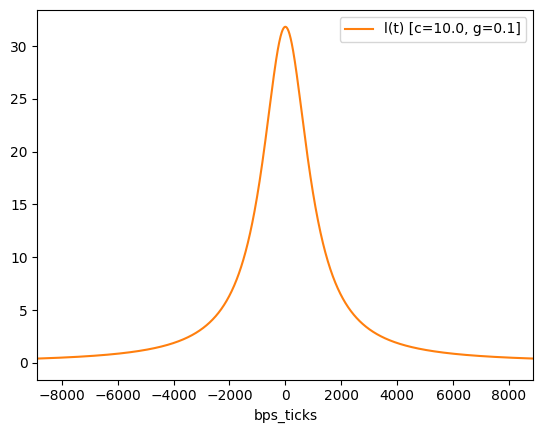

In [25]:
# plot +/- 60% 
df.plot(x='bps_ticks', y=f'l(t) [c={C}, g={GAMMA}]', xlim=(-MAX_TICK // 100, MAX_TICK // 100), color='C1')

In [26]:
# generate for more gammas
gammas = np.array([0.05, 0.1, 0.25, 0.5])

In [27]:
gammas

array([0.05, 0.1 , 0.25, 0.5 ])

In [28]:
for g in gammas:
    df[f'l(t) [c={C}, g={g}]'] = CauchyLiquidityProfile(c=C, gamma=g).at(log_ticks)

In [29]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.25]","l(t) [c=10.0, g=0.5]"
0,-887272,-88.722764,0.00004,0.00002,0.000101,0.000202
1,-887262,-88.721764,0.00004,0.00002,0.000101,0.000202
2,-887252,-88.720764,0.00004,0.00002,0.000101,0.000202
3,-887242,-88.719764,0.00004,0.00002,0.000101,0.000202
4,-887232,-88.718764,0.00004,0.00002,0.000101,0.000202
...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.00002,0.000101,0.000202
177451,887238,88.719364,0.00004,0.00002,0.000101,0.000202
177452,887248,88.720364,0.00004,0.00002,0.000101,0.000202
177453,887258,88.721364,0.00004,0.00002,0.000101,0.000202


<Axes: xlabel='bps_ticks'>

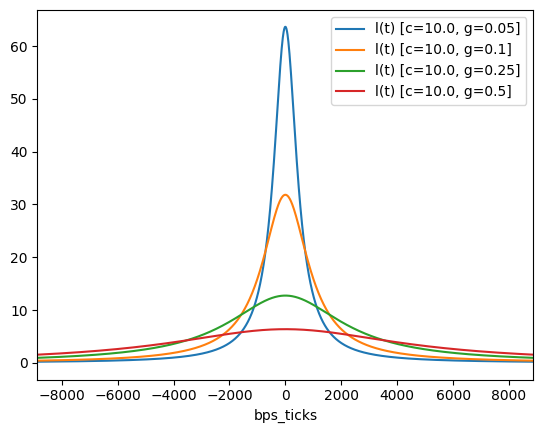

In [30]:
df.plot(x='bps_ticks', y=[f'l(t) [c={C}, g={g}]' for g in gammas], xlim=(-MAX_TICK // 100, MAX_TICK // 100))